In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!ls /content/gdrive/MyDrive/custom_data/

Dataset.zip  model.pth	Test  Train


In [ ]:
!unzip /content/gdrive/MyDrive/custom_data/Dataset.zip -d /content/gdrive/MyDrive/custom_data

Archive:  /content/gdrive/MyDrive/custom_data/Dataset.zip
replace /content/gdrive/MyDrive/custom_data/Test/Bald/173201.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import torch

#데이터 불러오기
train_set = torchvision.datasets.ImageFolder(root='/content/gdrive/MyDrive/custom_data/Train',
                                             transform= transforms.ToTensor())
test_set = torchvision.datasets.ImageFolder(root='/content/gdrive/MyDrive/custom_data/Test',
                                             transform= transforms.ToTensor())

#데이터파일 저장 및 불러오기
#torch.save(net, '/content/gdrive/MyDrive/custom_data/model.pth')
#net = torch.load('/content/gdrive/MyDrive/custom_data/model.pth')

print(train_set.classes, test_set.classes)
print(len(train_set), len(test_set))

['Bald', 'NotBald'] ['Bald', 'NotBald']
6591 410


====== Epoch:  1 / 1 ======
Batch: 10/132  Loss: 0.339070
Batch: 20/132  Loss: 0.316612
Batch: 30/132  Loss: 0.353283
Batch: 40/132  Loss: 0.272459
Batch: 50/132  Loss: 0.273923
Batch: 60/132  Loss: 0.274877
Batch: 70/132  Loss: 0.204878
Batch: 80/132  Loss: 0.304124
Batch: 90/132  Loss: 0.127859
Batch: 100/132  Loss: 0.213151
Batch: 110/132  Loss: 0.091769
Batch: 120/132  Loss: 0.182525
Batch: 130/132  Loss: 0.232633
Accuracy: 94.15%
elapsed time: 58.591001987457275
total time: 58.59146165847778
Answer = not bald
Predict= not bald


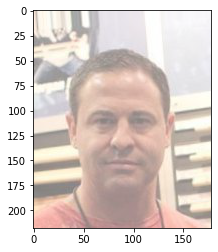

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
import time
from torchvision.models import vgg19  #vgg19를 불러와 전이학습하기 위함

#gpu
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                   #gpu사용가능(True)하면 'cuda' 불가능(False)하면 'cpu'
transform = T.Compose([T.ToTensor(),
                       T.Resize((224,224))])

#데이터 불러오기
train_set = torchvision.datasets.ImageFolder(root="/content/gdrive/MyDrive/custom_data/Train",
                                              transform=transforms.ToTensor())

test_set = torchvision.datasets.ImageFolder(root="/content/gdrive/MyDrive/custom_data/Test",
                                              transform=transforms.ToTensor())

#DataLoader
BATCH_SIZE = 50
train_loader = DataLoader(dataset=train_set,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=0)
test_loader = DataLoader(dataset=test_set,
                          batch_size=10,
                          shuffle=False,
                          num_workers=0)

net = vgg19(pretrained=True)  #오차 역전파를 이용하여 가중치 업그레이드

#사전학습된 인공신경망을 고정된 특징 추출기로 사용
for param in net.features.parameters(): #feature extraction부분이 학습되지않도록 설정
    param.requires_grad = False    #feature extraction부분의 가중치는 학습되더라도 변하면 안됨
                                   #(역전파 추적X)

net.classifier[6] = torch.nn.Linear(4096, 2) #소프트맥스 분류기의 출력을 2개로 조절
net.to(DEVICE)

#Optimizer와 loss function
cel = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

#학습 과정 코드
EPOCHS = 1
loss_lst = []
acc_lst = []
start_time = time.time()
for epoch in range(EPOCHS):
    batch_time = time.time()
    print(f'====== Epoch: {epoch+1:2d} / {EPOCHS} ======')
    net.train()
    l_sum = 0
    for batch_idx, (x,y) in enumerate(train_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        z = net(x)
        loss = cel(z, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        l_sum += loss.item()
        if (batch_idx+1) % 10 == 0:
            print(f'Batch: {batch_idx+1:2d}/{len(train_loader)} ',
                f'Loss: {loss.item():0.6f}')

    loss_lst.append(l_sum/len(train_loader))

    net.eval()
    correct = 0
    with torch.no_grad():
        for batch_idx, (x,y) in enumerate(test_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            z = net(x)
            yhat = torch.argmax(z, dim=1)
            correct += torch.sum(y==yhat)

    accuracy = correct / len(test_set)
    acc_lst.append(accuracy)
    print(f'Accuracy: {accuracy.item()*100:0.2f}%')
    print("elapsed time:", time.time() - batch_time)

print("total time:", time.time() - start_time)
import matplotlib.pyplot as plt
import numpy as np

#사진 출력코드
def matplotlib_imshow(img, one_channel = False):
  if one_channel:
      img= img.mean(dim = 0)
  img = img / 2+0.5
  npimg = img.numpy()
  if one_channel:
      plt.imshow(npimg,cmap ="Greys")
  else:
      plt.imshow(np.transpose(npimg,(1,2,0)))

test_index = 350  #몇번째 사진인지 나타냄
classes = ('blad','not bald')
print('Answer =',classes[test_set[test_index][1]]) #실제
matplotlib_imshow(test_set[test_index][0]) #사진출력

with torch.no_grad():
  net.eval()
  x=test_set[test_index][0].view(1,3,178,218).to(DEVICE)
  yhat =net(x)
  print('Predict=',classes[torch.max(yhat,1)[1]]) #예측값 확률큰것

torch.save(net, '/content/gdrive/MyDrive/custom_data/model.pth')

In [ ]:
import torch
net = torch.load('/content/gdrive/MyDrive/custom_data/model.pth')
net.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd